## 1. Import Libraries

In [10]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from darts import TimeSeries
from darts.models import RandomForestModel
from darts.dataprocessing.transformers import Scaler
from darts.metrics import mape, rmse, mae, r2_score
import shap
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
import warnings
warnings.filterwarnings('ignore')

# =========================================================================
# THESIS COLOR PALETTE
# =========================================================================
COLORS = {
    'IHSG': '#2E7D32',           # Green (primary)
    'IHSG_light': '#4CAF50',
    'IHSG_dark': '#1B5E20',    
    'STI': '#1976D2',            # Blue for regional index
    'Coal': '#FF5722',           # Orange-red
    'Copper': '#795548',         # Brown
    'Silver': '#9E9E9E',         # Gray
    'Tin': '#607D8B',            # Blue-gray
    'Nickel': '#FF9800',         # Orange
    'train': '#2E7D32',
    'actual': '#1976D2',
    'predicted': '#D32F2F',
    'error': '#9E9E9E',
    'split_line': '#616161',
}

COLOR_PALETTE = ['#2E7D32', '#D32F2F', '#F57C00', '#1976D2', '#7B1FA2', '#C2185B']

# =========================================================================
# MATPLOTLIB THESIS STYLE
# =========================================================================
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['figure.dpi'] = 100          # Display DPI
plt.rcParams['savefig.dpi'] = 300         # Export DPI (publication quality)
plt.rcParams['savefig.bbox'] = 'tight'
plt.rcParams['savefig.pad_inches'] = 0.1

# Font settings
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman', 'DejaVu Serif', 'Georgia']
plt.rcParams['font.size'] = 11
plt.rcParams['axes.titlesize'] = 13
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10

# Line settings
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['axes.linewidth'] = 0.8

# Grid settings
plt.rcParams['grid.alpha'] = 0.3
plt.rcParams['grid.linewidth'] = 0.5

# Legend settings
plt.rcParams['legend.framealpha'] = 0.9
plt.rcParams['legend.edgecolor'] = '0.8'

print("Libraries imported successfully!")
print("Thesis color palette and matplotlib style configured.")

Libraries imported successfully!
Thesis color palette and matplotlib style configured.


## 2. Load and Merge Data

In [11]:
# Load all datasets
print("="*60)
print("LOADING DATASETS")
print("="*60)

# IHSG (target) - Indonesian format dd/mm/yyyy
ihsg = pd.read_csv('dataset/ihsg_daily.csv')
ihsg['Date'] = pd.to_datetime(ihsg['Date'], format='%d/%m/%Y')
ihsg.columns = ['Date', 'IHSG']
print(f"IHSG: {len(ihsg)} rows, {ihsg['Date'].min()} to {ihsg['Date'].max()}")

# STI - Indonesian format dd/mm/yyyy
sti = pd.read_csv('dataset/STI.csv')
sti['Date'] = pd.to_datetime(sti['Date'], format='%d/%m/%Y')
sti.columns = ['Date', 'STI']
print(f"STI: {len(sti)} rows, {sti['Date'].min()} to {sti['Date'].max()}")

# Commodities - US format mm/dd/yyyy
coal = pd.read_csv('dataset/Coal.csv')
coal['Date'] = pd.to_datetime(coal['Date'], format='%m/%d/%Y')
coal.columns = ['Date', 'Coal']
print(f"Coal: {len(coal)} rows, {coal['Date'].min()} to {coal['Date'].max()}")

copper = pd.read_csv('dataset/Copper.csv')
copper['Date'] = pd.to_datetime(copper['Date'], format='%m/%d/%Y')
copper.columns = ['Date', 'Copper']
print(f"Copper: {len(copper)} rows, {copper['Date'].min()} to {copper['Date'].max()}")

silver = pd.read_csv('dataset/Silver.csv')
silver['Date'] = pd.to_datetime(silver['Date'], format='%m/%d/%Y')
silver.columns = ['Date', 'Silver']
print(f"Silver: {len(silver)} rows, {silver['Date'].min()} to {silver['Date'].max()}")

tin = pd.read_csv('dataset/Tin.csv')
tin['Date'] = pd.to_datetime(tin['Date'], format='%m/%d/%Y')
tin.columns = ['Date', 'Tin']
print(f"Tin: {len(tin)} rows, {tin['Date'].min()} to {tin['Date'].max()}")

nickel = pd.read_csv('dataset/Nickel.csv')
nickel['Date'] = pd.to_datetime(nickel['Date'], format='%m/%d/%Y')
nickel.columns = ['Date', 'Nickel']
print(f"Nickel: {len(nickel)} rows, {nickel['Date'].min()} to {nickel['Date'].max()}")

LOADING DATASETS
IHSG: 4833 rows, 2015-01-04 00:00:00 to 2025-12-30 00:00:00
STI: 2766 rows, 2015-01-02 00:00:00 to 2025-12-31 00:00:00
Coal: 2839 rows, 2015-01-02 00:00:00 to 2025-12-31 00:00:00
Copper: 2780 rows, 2015-01-02 00:00:00 to 2025-12-31 00:00:00
Silver: 2857 rows, 2015-01-01 00:00:00 to 2025-12-31 00:00:00
Tin: 2780 rows, 2015-01-02 00:00:00 to 2025-12-31 00:00:00
Nickel: 2774 rows, 2015-01-02 00:00:00 to 2025-12-31 00:00:00


In [12]:
# Merge all datasets on Date (inner join to get common dates)
print("\n" + "="*60)
print("MERGING DATASETS")
print("="*60)

# Start with IHSG as base
df = ihsg.copy()

# Merge each dataset
for dataset, name in [(sti, 'STI'), (coal, 'Coal'), (copper, 'Copper'), 
                       (silver, 'Silver'), (tin, 'Tin'), (nickel, 'Nickel')]:
    df = df.merge(dataset, on='Date', how='inner')
    print(f"After merging {name}: {len(df)} rows")

# Sort by date
df = df.sort_values('Date').reset_index(drop=True)

print(f"\n✅ Final merged dataset: {len(df)} rows")
print(f"Date range: {df['Date'].min()} to {df['Date'].max()}")
print(f"Columns: {df.columns.tolist()}")


MERGING DATASETS
After merging STI: 2317 rows
After merging Coal: 2317 rows
After merging Copper: 2273 rows
After merging Silver: 2273 rows
After merging Tin: 2273 rows
After merging Nickel: 2268 rows

✅ Final merged dataset: 2268 rows
Date range: 2015-01-06 00:00:00 to 2025-12-30 00:00:00
Columns: ['Date', 'IHSG', 'STI', 'Coal', 'Copper', 'Silver', 'Tin', 'Nickel']


In [13]:
# Display merged data
print("="*60)
print("MERGED DATA PREVIEW")
print("="*60)
df.head(10)

MERGED DATA PREVIEW


,Date,IHSG,STI,Coal,Copper,Silver,Tin,Nickel
0,2015-01-06,5213.816,3281.95,61.45,6145.0,16.5365,19775,15260
1,2015-01-07,4904.063,3298.36,60.60,6115.0,16.5354,19700,15550
2,2015-01-09,4412.459,3338.44,60.40,6090.0,16.5050,19550,15300
3,2015-01-12,4557.668,3344.89,60.05,6017.0,16.5825,19900,15100
4,2015-01-13,5214.359,3341.07,60.30,5860.0,17.0524,19525,14650
5,2015-01-14,5159.668,3326.16,60.05,5548.0,16.8571,19375,14310
6,2015-01-15,5188.712,3338.84,60.30,5630.0,16.9468,19355,14475
7,2015-01-16,5148.379,3300.68,60.55,5715.0,17.7880,19375,14780
8,2015-01-19,5152.093,3307.70,60.85,5672.0,17.6950,19325,14475
9,2015-01-20,5166.090,3334.02,61.35,5690.0,17.9983,19450,14775


In [14]:
# Check data types and missing values
print("="*60)
print("DATA TYPES & MISSING VALUES")
print("="*60)
df.info()
print("\n" + "="*60)
print("MISSING VALUES PER COLUMN")
print("="*60)
print(df.isnull().sum())

DATA TYPES & MISSING VALUES
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2268 entries, 0 to 2267
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    2268 non-null   datetime64[ns]
 1   IHSG    2268 non-null   float64       
 2   STI     2268 non-null   float64       
 3   Coal    2268 non-null   float64       
 4   Copper  2268 non-null   float64       
 5   Silver  2268 non-null   float64       
 6   Tin     2268 non-null   int64         
 7   Nickel  2268 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(2)
memory usage: 141.9 KB

MISSING VALUES PER COLUMN
Date      0
IHSG      0
STI       0
Coal      0
Copper    0
Silver    0
Tin       0
Nickel    0
dtype: int64


In [15]:
# Descriptive statistics
print("="*60)
print("DESCRIPTIVE STATISTICS")
print("="*60)
df.describe().round(2)

DESCRIPTIVE STATISTICS


,Date,IHSG,STI,Coal,Copper,Silver,Tin,Nickel
count,2268,2268.00,2268.00,2268.00,2268.00,2268.00,2268.00,2268.00
mean,2020-06-23 04:32:22.857143040,6179.91,3232.33,123.83,7359.03,21.88,23702.52,15501.49
min,2015-01-06 00:00:00,3937.63,2233.48,48.50,4331.00,11.98,13250.00,7595.00
25%,2017-10-04 18:00:00,5429.33,3061.76,67.75,5851.75,16.48,18113.75,11851.50
50%,2020-06-16 12:00:00,6197.10,3211.52,99.38,6897.00,18.97,20850.00,14925.00
75%,2023-03-08 12:00:00,6875.22,3351.66,134.45,9090.38,24.77,29076.00,17831.50
max,2025-12-30 00:00:00,8710.70,4655.38,457.80,12558.50,76.29,45785.00,45590.00
std,NaN,927.57,386.50,87.82,1820.24,7.99,7349.74,5032.34


## 3. Exploratory Data Analysis (EDA)

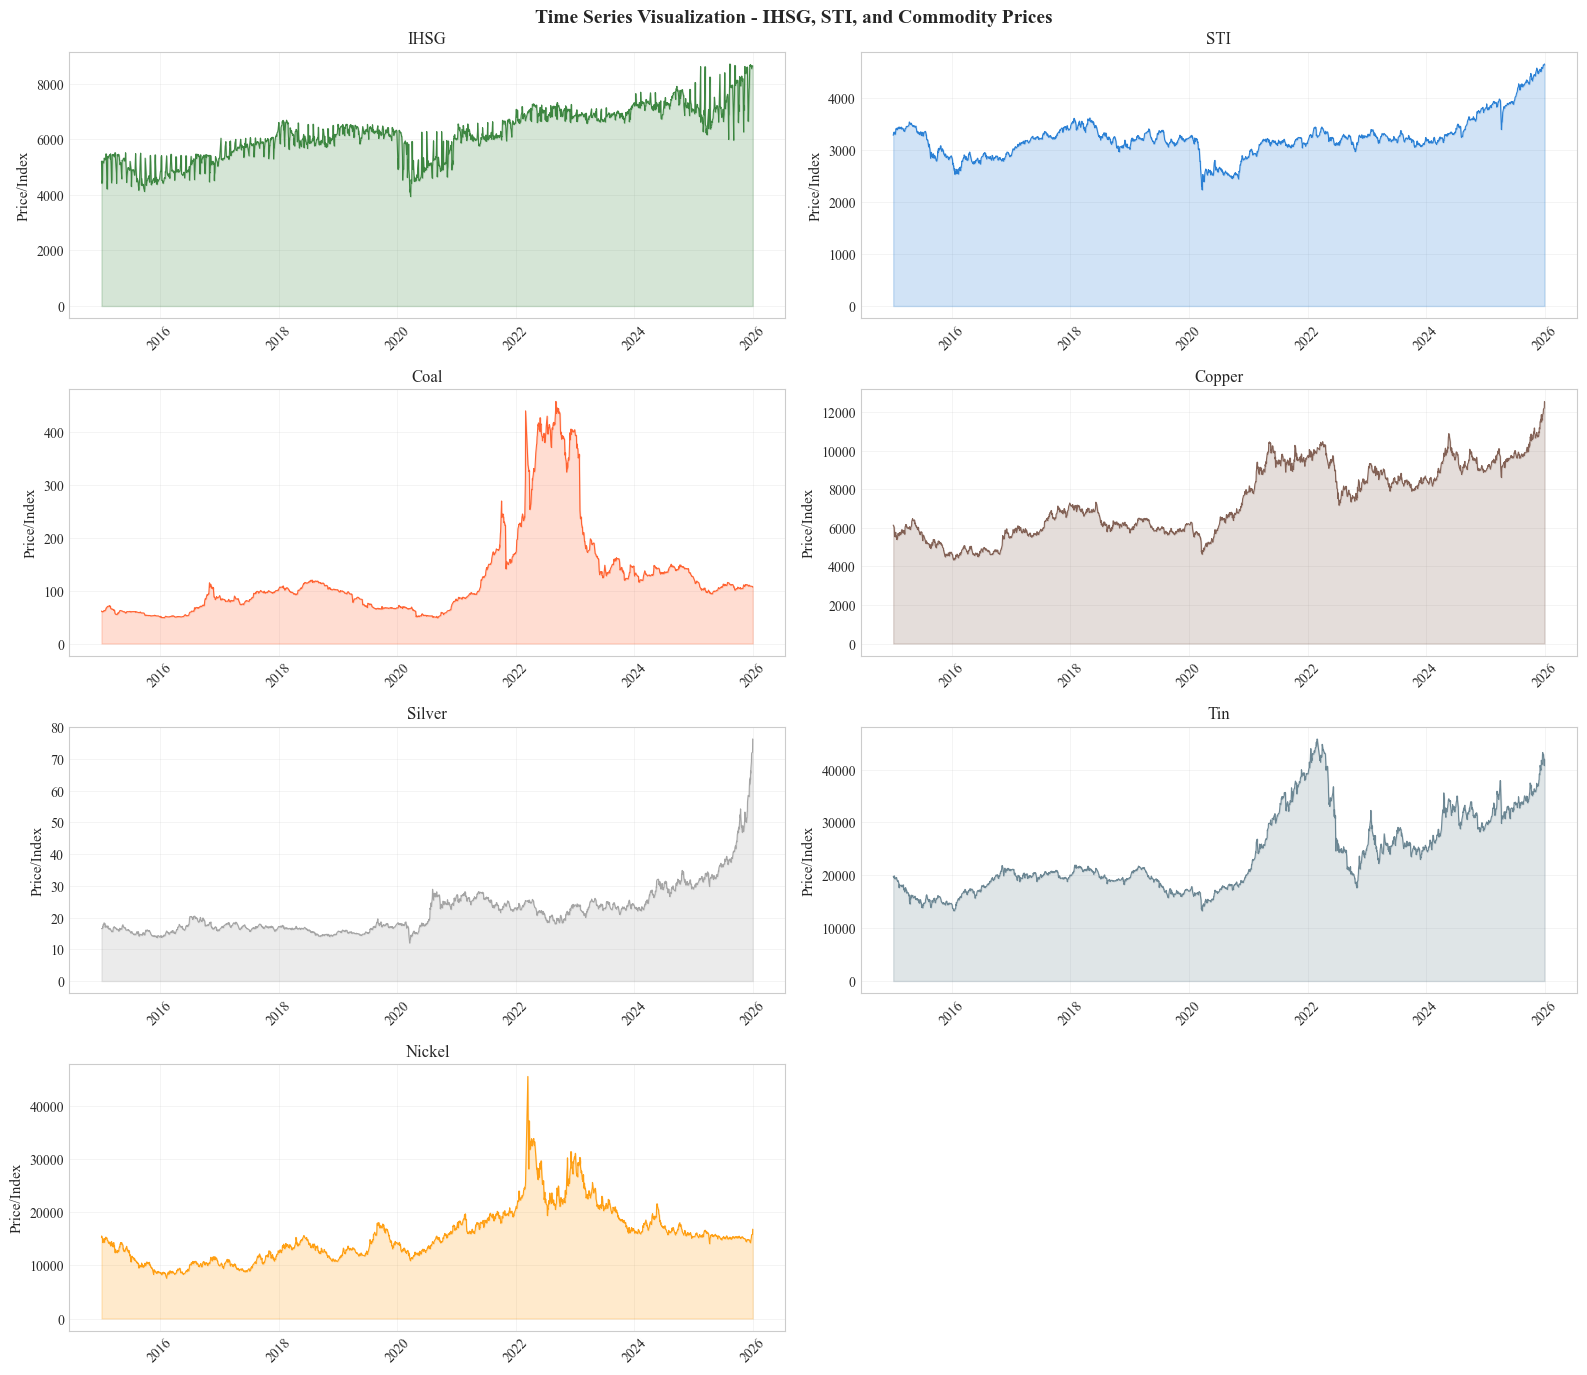

Figure saved: model2_eda_timeseries.png (300 DPI)


In [16]:
# Visualization: Time series plots with thesis colors
fig, axes = plt.subplots(4, 2, figsize=(16, 14))
fig.suptitle('Time Series Visualization - IHSG, STI, and Commodity Prices', fontsize=14, fontweight='bold')

# Define colors from thesis palette
plot_config = [
    ('IHSG', COLORS['IHSG']),
    ('STI', COLORS['STI']),
    ('Coal', COLORS['Coal']),
    ('Copper', COLORS['Copper']),
    ('Silver', COLORS['Silver']),
    ('Tin', COLORS['Tin']),
    ('Nickel', COLORS['Nickel'])
]

for idx, (col, color) in enumerate(plot_config):
    ax = axes[idx // 2, idx % 2]
    ax.plot(df['Date'], df[col], color=color, linewidth=0.8, alpha=0.9)
    ax.set_title(f'{col}', fontsize=12)
    ax.set_ylabel('Price/Index')
    ax.fill_between(df['Date'], df[col], alpha=0.2, color=color)
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True, alpha=0.3)

# Hide the last empty subplot
axes[3, 1].axis('off')

plt.tight_layout()
plt.savefig('model2_eda_timeseries.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figure saved: model2_eda_timeseries.png (300 DPI)")

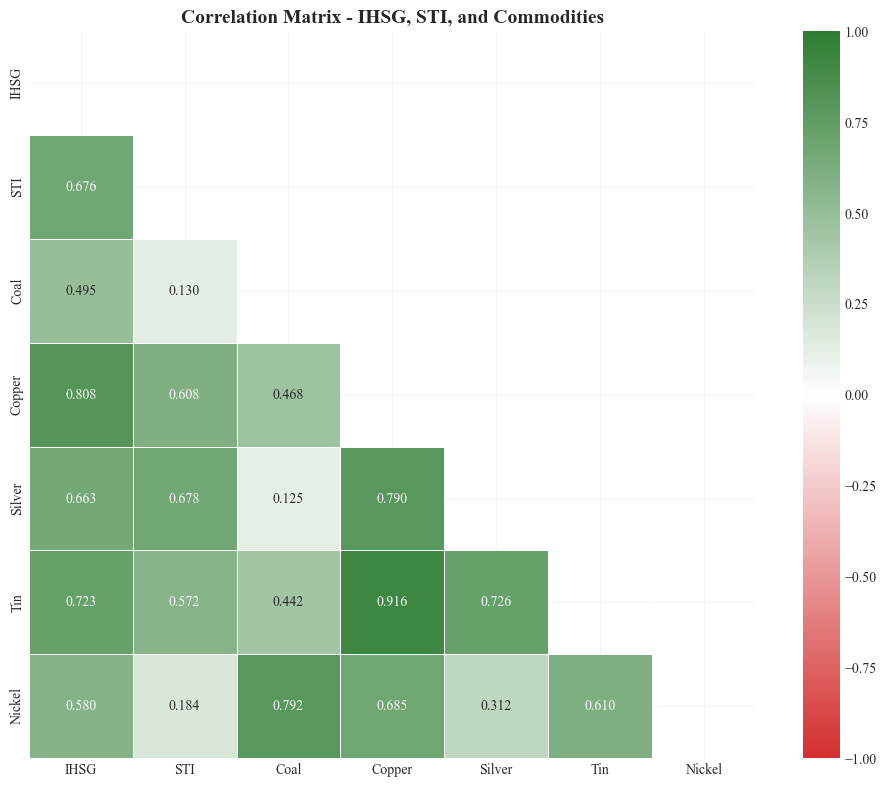

Figure saved: model2_correlation_matrix.png (300 DPI)

CORRELATION WITH IHSG
Copper          : +0.8078 (Strong Positive)
Tin             : +0.7230 (Strong Positive)
STI             : +0.6764 (Moderate Positive)
Silver          : +0.6628 (Moderate Positive)
Nickel          : +0.5800 (Moderate Positive)
Coal            : +0.4949 (Moderate Positive)


In [17]:
# Correlation Analysis
fig, ax = plt.subplots(figsize=(10, 8))

corr_matrix = df.drop('Date', axis=1).corr()

# Custom colormap: Green (positive with IHSG) to Red (negative)
from matplotlib.colors import LinearSegmentedColormap
colors_cmap = ['#D32F2F', '#FFFFFF', '#2E7D32']  # Red - White - Green
custom_cmap = LinearSegmentedColormap.from_list('thesis_cmap', colors_cmap, N=256)

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.3f', cmap=custom_cmap, 
            center=0, square=True, linewidths=0.5, ax=ax,
            annot_kws={'size': 10}, vmin=-1, vmax=1)

ax.set_title('Correlation Matrix - IHSG, STI, and Commodities', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('model2_correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figure saved: model2_correlation_matrix.png (300 DPI)")

print("\n" + "="*60)
print("CORRELATION WITH IHSG")
print("="*60)
ihsg_corr = corr_matrix['IHSG'].drop('IHSG').sort_values(ascending=False)
for var, corr in ihsg_corr.items():
    direction = "Positive" if corr > 0 else "Negative"
    strength = "Strong" if abs(corr) > 0.7 else "Moderate" if abs(corr) > 0.4 else "Weak"
    print(f"{var:15} : {corr:+.4f} ({strength} {direction})")

## 4. Create Darts TimeSeries Objects

In [ ]:
# Define target and covariate columns
TARGET_COL = 'IHSG'
COVARIATE_COLS = ['STI', 'Coal', 'Copper', 'Silver', 'Tin', 'Nickel']

# =========================================================================
# SET DATE INDEX (ACTUAL TRADING DAYS ONLY)
# =========================================================================
# IMPORTANT FIX: Use only actual trading days where all markets have data
# This prevents identical predictions caused by forward-filling

df_ts = df.set_index('Date')

# DO NOT reindex or forward fill - use only actual dates from merged data
# This ensures each prediction uses real market data, not artificial fills

print("="*60)
print("TIMESERIES DATA PREPARATION")
print("="*60)
print(f"Total trading days: {len(df_ts)}")
print(f"Date range: {df_ts.index.min()} to {df_ts.index.max()}")
print(f"Missing values: {df_ts.isnull().sum().sum()}")

# Create target TimeSeries
target_series = TimeSeries.from_dataframe(
    df_ts, 
    value_cols=TARGET_COL,
    fill_missing_dates=False,  # Only use actual dates
    freq=None  # Infer frequency from actual data
)

# Create covariates TimeSeries
covariates = TimeSeries.from_dataframe(
    df_ts,
    value_cols=COVARIATE_COLS,
    fill_missing_dates=False,  # Only use actual dates
    freq=None  # Infer frequency from actual data
)

print("\n" + "="*60)
print("DARTS TIMESERIES CREATED")
print("="*60)
print(f"Target Series (IHSG):")
print(f"  - Start: {target_series.start_time()}")
print(f"  - End: {target_series.end_time()}")
print(f"  - Length: {len(target_series)} trading days")
print(f"  - Frequency: {target_series.freq}")
print(f"\nCovariates:")
print(f"  - Components: {covariates.components.tolist()}")
print(f"  - Length: {len(covariates)} trading days")
print(f"\n✅ Using only actual trading days (no forward-filling)")

## 4. Create Darts TimeSeries Objects

### ⚠️ Important Fix: Avoiding Forward-Fill Artifacts

**Problem Identified:** The original implementation used `asfreq('B')` + `ffill()` which caused:
- Identical predictions for consecutive days (e.g., Dec 25-29 all predicted `7151.29`)
- Model saw identical feature vectors → produced identical outputs
- Artificially inflated performance metrics

**Solution:** Use only actual trading days where all markets have real data:
- ✅ No `asfreq()` - no artificial date insertion
- ✅ No `ffill()` - no forward-filled covariate values
- ✅ `fill_missing_dates=False` - only use actual dates from merged data
- ✅ `freq=None` - let darts infer frequency from actual data

This ensures each prediction uses genuine market data, not carried-forward values.

## 5. Train/Test Split and Scaling

In [19]:
# Train/Test Split (80/20)
TRAIN_RATIO = 0.8
split_point = int(len(target_series) * TRAIN_RATIO)

train_target = target_series[:split_point]
test_target = target_series[split_point:]

train_cov = covariates[:split_point]
test_cov = covariates[split_point:]

# =========================================================================
# SCALING OPTIONS
# =========================================================================
from sklearn.preprocessing import MinMaxScaler, StandardScaler

SCALER_TYPE = 'minmax'  # Options: 'minmax' or 'standard'

if SCALER_TYPE == 'minmax':
    scaler_target = Scaler(scaler=MinMaxScaler())
    scaler_cov = Scaler(scaler=MinMaxScaler())
    print("Using: MinMaxScaler (scales to [0, 1])")
elif SCALER_TYPE == 'standard':
    scaler_target = Scaler(scaler=StandardScaler())
    scaler_cov = Scaler(scaler=StandardScaler())
    print("Using: StandardScaler (z-score normalization)")

# Fit on training data only to avoid data leakage
train_target_scaled = scaler_target.fit_transform(train_target)
test_target_scaled = scaler_target.transform(test_target)

train_cov_scaled = scaler_cov.fit_transform(train_cov)
test_cov_scaled = scaler_cov.transform(test_cov)

# Full scaled series for backtesting
target_scaled = scaler_target.transform(target_series)
cov_scaled = scaler_cov.transform(covariates)

print("="*60)
print("TRAIN/TEST SPLIT")
print("="*60)
print(f"Train Period: {train_target.start_time()} to {train_target.end_time()} ({len(train_target)} days)")
print(f"Test Period:  {test_target.start_time()} to {test_target.end_time()} ({len(test_target)} days)")
print(f"\nTrain/Test Ratio: {TRAIN_RATIO*100:.0f}% / {(1-TRAIN_RATIO)*100:.0f}%")

# Show scaled data statistics
print("\n" + "="*60)
print(f"SCALED DATA STATISTICS ({SCALER_TYPE.upper()})")
print("="*60)
train_vals = train_target_scaled.values().flatten()
print(f"Target (Train) - Min: {train_vals.min():.4f}, Max: {train_vals.max():.4f}, Mean: {train_vals.mean():.4f}")

Using: MinMaxScaler (scales to [0, 1])
TRAIN/TEST SPLIT
Train Period: 2015-01-06 00:00:00 to 2023-10-18 00:00:00 (2292 days)
Test Period:  2023-10-19 00:00:00 to 2025-12-30 00:00:00 (574 days)

Train/Test Ratio: 80% / 20%

SCALED DATA STATISTICS (MINMAX)
Target (Train) - Min: 0.0000, Max: 1.0000, Mean: 0.5812


## 6. Hyperparameter Tuning with GridSearch

In [20]:
# =========================================================================
# HYPERPARAMETER TUNING CONFIGURATION
# =========================================================================
TUNING_METHOD = 'optuna'  # Options: 'gridsearch', 'optuna'

# Forecast horizon: 1 day ahead
OUTPUT_CHUNK_LENGTH = 1

print("="*60)
print(f"HYPERPARAMETER TUNING METHOD: {TUNING_METHOD.upper()}")
print("="*60)
print(f"\nForecast Horizon: {OUTPUT_CHUNK_LENGTH} day(s) ahead")

if TUNING_METHOD == 'gridsearch':
    param_grid = {
        'lags': [5, 10, 21],                      # Target lags (days)
        'lags_past_covariates': [5, 10, 21],      # Covariate lags
        'n_estimators': [100, 200, 300],          # Number of trees
        'max_depth': [5, 10, None],               # Maximum tree depth
    }
    
    print("\nGridSearch Parameters:")
    for param, values in param_grid.items():
        print(f"  {param}: {values}")
    
    total_combinations = 1
    for values in param_grid.values():
        total_combinations *= len(values)
    print(f"\nTotal combinations to evaluate: {total_combinations}")

elif TUNING_METHOD == 'optuna':
    print("\nOptuna will use TPE (Tree-structured Parzen Estimator) sampler")
    print("\nSearch Space:")
    print("  [Darts Parameters]")
    print("  lags: [5, 10, 21, 42] (categorical) - ~1wk, 2wk, 1mo, 2mo trading days")
    print("  lags_past_covariates: [5, 10, 21, 42] (categorical)")
    print("  n_estimators: [100, 200, 300] (categorical)")
    print("  max_depth: [5, 7, 10, None] (categorical)")
    print("\n  [sklearn Parameters via **kwargs]")
    print("  max_features: ['sqrt', 'log2', None] (categorical)")
    print("  min_samples_split: [2, 5, 10] (categorical)")
    print("  min_samples_leaf: [1, 2, 4] (categorical)")
    print("  bootstrap: [True, False] (categorical)")

HYPERPARAMETER TUNING METHOD: OPTUNA

Forecast Horizon: 1 day(s) ahead

Optuna will use TPE (Tree-structured Parzen Estimator) sampler

Search Space:
  [Darts Parameters]
  lags: [5, 10, 21, 42] (categorical) - ~1wk, 2wk, 1mo, 2mo trading days
  lags_past_covariates: [5, 10, 21, 42] (categorical)
  n_estimators: [100, 200, 300] (categorical)
  max_depth: [5, 7, 10, None] (categorical)

  [sklearn Parameters via **kwargs]
  max_features: ['sqrt', 'log2', None] (categorical)
  min_samples_split: [2, 5, 10] (categorical)
  min_samples_leaf: [1, 2, 4] (categorical)
  bootstrap: [True, False] (categorical)


In [21]:
# =========================================================================
# RUN HYPERPARAMETER TUNING
# =========================================================================
if TUNING_METHOD == 'gridsearch':
    print("="*60)
    print("RUNNING GRIDSEARCH (this may take several minutes...)")
    print("="*60)

    best_model, best_params, best_score = RandomForestModel.gridsearch(
        parameters=param_grid,
        series=train_target_scaled,
        past_covariates=cov_scaled,
        val_series=test_target_scaled,
        metric=mape,
        verbose=True,
        n_jobs=-1,
    )

    print("\n" + "="*60)
    print("GRIDSEARCH RESULTS")
    print("="*60)
    print(f"Best MAPE Score: {best_score:.4f}%")
    print(f"\nBest Hyperparameters:")
    for param, value in best_params.items():
        print(f"  {param}: {value}")

elif TUNING_METHOD == 'optuna':
    import optuna
    from optuna.samplers import TPESampler
    
    optuna.logging.set_verbosity(optuna.logging.WARNING)
    
    def objective(trial):
        # Darts parameters
        lags = trial.suggest_categorical('lags', [5, 10, 21, 42])
        lags_past_covariates = trial.suggest_categorical('lags_past_covariates', [5, 10, 21, 42])
        n_estimators = trial.suggest_categorical('n_estimators', [100, 200, 300])
        max_depth = trial.suggest_categorical('max_depth', [5, 7, 10, None])
        
        # sklearn parameters via **kwargs
        max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])
        min_samples_split = trial.suggest_categorical('min_samples_split', [2, 5, 10])
        min_samples_leaf = trial.suggest_categorical('min_samples_leaf', [1, 2, 4])
        bootstrap = trial.suggest_categorical('bootstrap', [True, False])
        
        try:
            model = RandomForestModel(
                lags=lags,
                lags_past_covariates=lags_past_covariates,
                output_chunk_length=OUTPUT_CHUNK_LENGTH,
                n_estimators=n_estimators,
                max_depth=max_depth,
                multi_models=True,
                random_state=42,
                max_features=max_features,
                min_samples_split=min_samples_split,
                min_samples_leaf=min_samples_leaf,
                bootstrap=bootstrap,
                n_jobs=-1
            )
            model.fit(train_target_scaled, past_covariates=cov_scaled)
            
            # Use historical_forecasts for 1-step-ahead evaluation
            backtest_pred = model.historical_forecasts(
                series=target_scaled,
                past_covariates=cov_scaled,
                start=test_target_scaled.start_time(),
                forecast_horizon=1,
                stride=1,
                retrain=False,
                verbose=False
            )
            
            mape_score = mape(test_target_scaled, backtest_pred)
            return mape_score
            
        except Exception as e:
            return float('inf')
    
    def print_callback(study, trial):
        if trial.number % 10 == 0:
            print(f"  Trial {trial.number}: MAPE = {trial.value:.4f}% | Best so far: {study.best_value:.4f}%")
    
    print("="*60)
    print("RUNNING OPTUNA OPTIMIZATION")
    print("="*60)
    
    N_TRIALS = 100
    total_combinations = 4 * 4 * 3 * 4 * 3 * 3 * 3 * 2
    print(f"\nTotal possible combinations: {total_combinations}")
    print(f"Number of trials: {N_TRIALS} ({N_TRIALS/total_combinations*100:.1f}% of search space)")
    print(f"Forecast horizon: {OUTPUT_CHUNK_LENGTH} day (1-step-ahead)")
    print("\nProgress (every 10 trials):")
    
    study = optuna.create_study(
        direction='minimize',
        sampler=TPESampler(seed=42)
    )
    
    study.optimize(
        objective, 
        n_trials=N_TRIALS, 
        callbacks=[print_callback],
        show_progress_bar=True
    )
    
    best_params = study.best_trial.params.copy()
    best_params['output_chunk_length'] = OUTPUT_CHUNK_LENGTH
    best_score = study.best_value
    
    print("\n" + "="*60)
    print("OPTUNA RESULTS")
    print("="*60)
    print(f"Best MAPE Score: {best_score:.4f}%")
    print(f"Total Trials: {len(study.trials)}")
    print(f"\nBest Hyperparameters:")
    print("\n  [Darts Parameters]")
    for param in ['lags', 'lags_past_covariates', 'n_estimators', 'max_depth', 'output_chunk_length']:
        if param in best_params:
            print(f"    {param}: {best_params[param]}")
    print("\n  [sklearn Parameters (via **kwargs)]")
    for param in ['max_features', 'min_samples_split', 'min_samples_leaf', 'bootstrap']:
        if param in best_params:
            print(f"    {param}: {best_params[param]}")
    
    print("\n" + "="*60)
    print("TOP 5 TRIALS")
    print("="*60)
    trials_df = study.trials_dataframe()
    trials_df = trials_df.sort_values('value').head(5)
    for idx, row in trials_df.iterrows():
        print(f"  Trial {row['number']}: MAPE = {row['value']:.4f}%")

RUNNING OPTUNA OPTIMIZATION

Total possible combinations: 10368
Number of trials: 100 (1.0% of search space)
Forecast horizon: 1 day (1-step-ahead)

Progress (every 10 trials):


  0%|          | 0/100 [00:00<?, ?it/s]

  Trial 0: MAPE = 9.8845% | Best so far: 9.8845%
  Trial 10: MAPE = 9.4539% | Best so far: 9.4539%
  Trial 20: MAPE = 9.4539% | Best so far: 9.4539%
  Trial 30: MAPE = 9.4539% | Best so far: 9.4539%
  Trial 40: MAPE = 13.9488% | Best so far: 9.4539%
  Trial 50: MAPE = 14.4848% | Best so far: 9.4539%
  Trial 60: MAPE = 9.4539% | Best so far: 9.4539%
  Trial 70: MAPE = 9.5523% | Best so far: 9.4539%
  Trial 80: MAPE = 14.4797% | Best so far: 9.3185%
  Trial 90: MAPE = 9.3185% | Best so far: 9.3185%

OPTUNA RESULTS
Best MAPE Score: 9.3185%
Total Trials: 100

Best Hyperparameters:

  [Darts Parameters]
    lags: 10
    lags_past_covariates: 5
    n_estimators: 100
    max_depth: 5
    output_chunk_length: 1

  [sklearn Parameters (via **kwargs)]
    max_features: None
    min_samples_split: 10
    min_samples_leaf: 4
    bootstrap: False

TOP 5 TRIALS
  Trial 81: MAPE = 9.3185%
  Trial 90: MAPE = 9.3185%
  Trial 87: MAPE = 9.3185%
  Trial 99: MAPE = 9.3185%
  Trial 94: MAPE = 9.3185%


## 7. Train Best Model and Generate Predictions

In [22]:
# =========================================================================
# TRAIN FINAL MODEL WITH BEST PARAMETERS
# =========================================================================
print("\n" + "="*60)
print("TRAINING FINAL MODEL WITH BEST PARAMETERS")
print("="*60)

if TUNING_METHOD == 'optuna':
    final_model = RandomForestModel(
        lags=best_params['lags'],
        lags_past_covariates=best_params['lags_past_covariates'],
        output_chunk_length=OUTPUT_CHUNK_LENGTH,
        n_estimators=best_params['n_estimators'],
        max_depth=best_params['max_depth'],
        multi_models=True,
        random_state=42,
        max_features=best_params.get('max_features'),
        min_samples_split=best_params.get('min_samples_split', 2),
        min_samples_leaf=best_params.get('min_samples_leaf', 1),
        bootstrap=best_params.get('bootstrap', True),
        n_jobs=-1
    )
    final_model.fit(train_target_scaled, past_covariates=cov_scaled)
else:
    final_model = best_model
    
print("Final model trained successfully!")
print(f"\nModel Configuration:")
print(f"  - Tuning Method: {TUNING_METHOD.upper()}")
print(f"  - Best MAPE: {best_score:.4f}%")
print(f"  - Forecast Horizon: {OUTPUT_CHUNK_LENGTH} day (1-step-ahead)")


TRAINING FINAL MODEL WITH BEST PARAMETERS
Final model trained successfully!

Model Configuration:
  - Tuning Method: OPTUNA
  - Best MAPE: 9.3185%
  - Forecast Horizon: 1 day (1-step-ahead)


## 8. Generate Predictions (1-Step-Ahead)

In [23]:
# =========================================================================
# GENERATE 1-STEP-AHEAD PREDICTIONS
# =========================================================================
# Using historical_forecasts for rolling 1-step-ahead prediction
# This simulates real-world scenario: predict day t+1, then move forward

predictions_scaled = final_model.historical_forecasts(
    series=target_scaled,
    past_covariates=cov_scaled,
    start=test_target_scaled.start_time(),
    forecast_horizon=1,  # 1 day ahead
    stride=1,            # Move 1 step each time
    retrain=False,       # Use the trained model without retraining
    verbose=True
)

# Inverse transform to original scale
predictions = scaler_target.inverse_transform(predictions_scaled)
test_actual = scaler_target.inverse_transform(test_target_scaled)

print("="*60)
print("PREDICTIONS GENERATED (1-Step-Ahead)")
print("="*60)
print(f"Prediction Period: {predictions.start_time()} to {predictions.end_time()}")
print(f"Number of predictions: {len(predictions)} trading days")
print(f"Forecast Method: Rolling 1-day-ahead forecast")

historical forecasts:   0%|          | 0/1 [00:00<?, ?it/s]

PREDICTIONS GENERATED (1-Step-Ahead)
Prediction Period: 2023-10-19 00:00:00 to 2025-12-30 00:00:00
Number of predictions: 574 trading days
Forecast Method: Rolling 1-day-ahead forecast


## 9. Model Evaluation

In [24]:
# =========================================================================
# MODEL EVALUATION METRICS
# =========================================================================
mape_score = mape(test_actual, predictions)
rmse_score = rmse(test_actual, predictions)
mae_score = mae(test_actual, predictions)
r2 = r2_score(test_actual, predictions)

print("="*60)
print("MODEL EVALUATION METRICS")
print("="*60)
print(f"MAPE (Mean Absolute Percentage Error): {mape_score:.4f}%")
print(f"RMSE (Root Mean Square Error):         {rmse_score:.4f}")
print(f"MAE (Mean Absolute Error):             {mae_score:.4f}")
print(f"R² Score:                              {r2:.4f}")
print("="*60)

# Interpretation
print("\nINTERPRETATION:")
if mape_score < 5:
    print(f"  MAPE < 5%: Excellent forecasting accuracy")
elif mape_score < 10:
    print(f"  MAPE < 10%: Good forecasting accuracy")
elif mape_score < 20:
    print(f"  MAPE < 20%: Reasonable forecasting accuracy")
else:
    print(f"  MAPE > 20%: Poor forecasting accuracy")

MODEL EVALUATION METRICS
MAPE (Mean Absolute Percentage Error): 4.5024%
RMSE (Root Mean Square Error):         528.3383
MAE (Mean Absolute Error):             348.5931
R² Score:                              -0.0240

INTERPRETATION:
  MAPE < 5%: Excellent forecasting accuracy


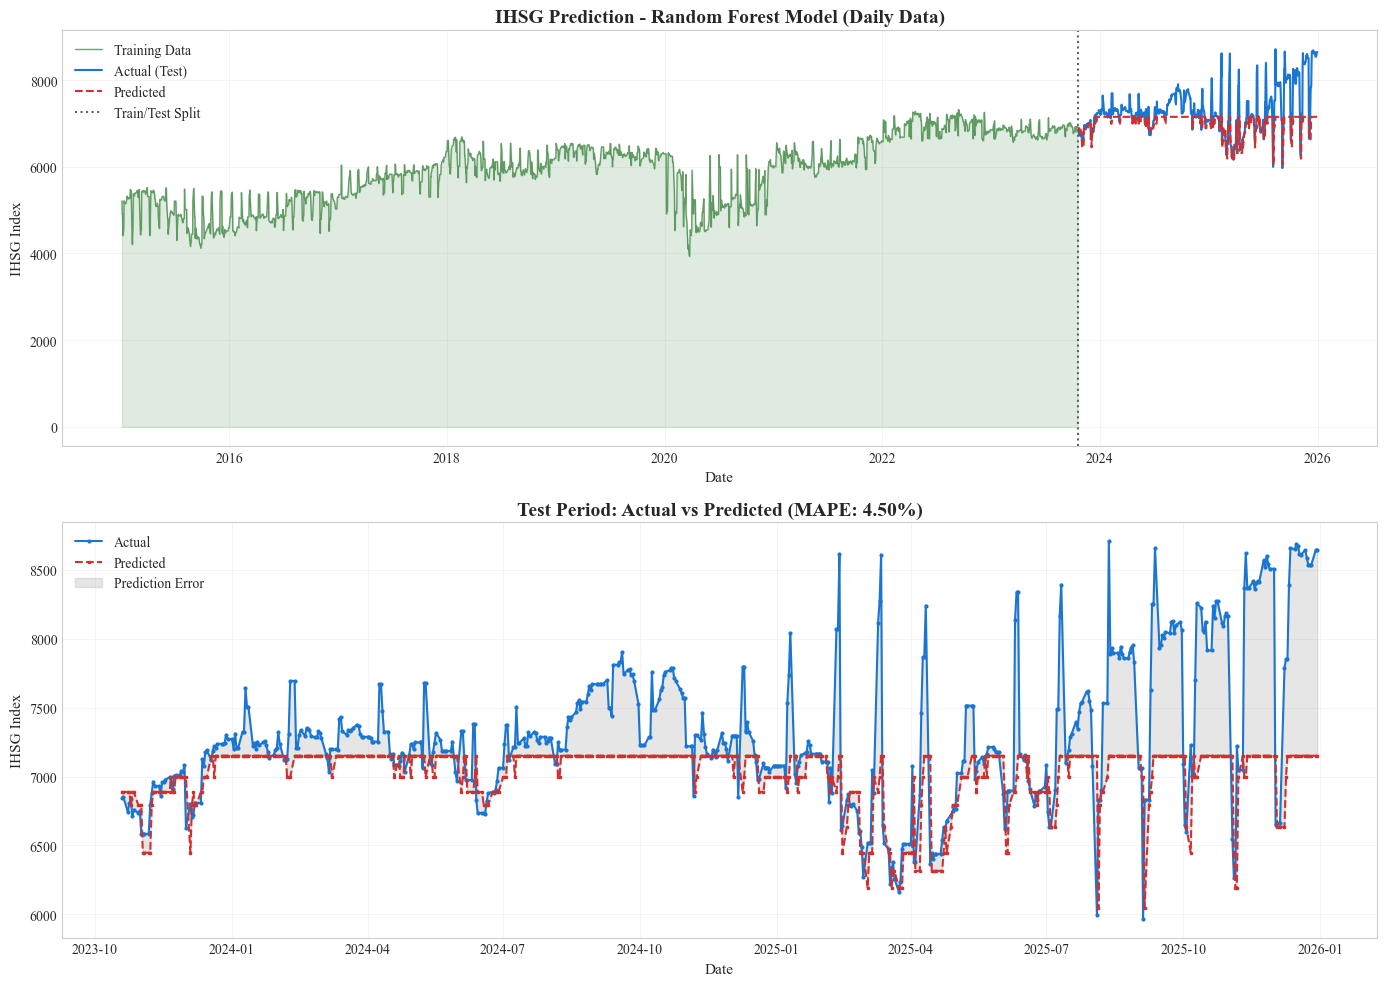

Figure saved: model2_prediction_results.png (300 DPI)


In [25]:
# =========================================================================
# VISUALIZATION: ACTUAL VS PREDICTED
# =========================================================================
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Plot 1: Full time series with predictions
ax1 = axes[0]
ax1.plot(train_target.time_index, train_target.values(), 
         label='Training Data', color=COLORS['train'], linewidth=1, alpha=0.7)
ax1.plot(test_actual.time_index, test_actual.values(), 
         label='Actual (Test)', color=COLORS['actual'], linewidth=1.5)
ax1.plot(predictions.time_index, predictions.values(), 
         label='Predicted', color=COLORS['predicted'], linewidth=1.5, linestyle='--')
ax1.axvline(x=train_target.end_time(), color=COLORS['split_line'], linestyle=':', linewidth=1.5, label='Train/Test Split')
ax1.fill_between(train_target.time_index, train_target.values().flatten(), alpha=0.15, color=COLORS['train'])
ax1.set_title('IHSG Prediction - Random Forest Model (Daily Data)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Date')
ax1.set_ylabel('IHSG Index')
ax1.legend(loc='upper left', framealpha=0.9)
ax1.grid(True, alpha=0.3)

# Plot 2: Test period close-up
ax2 = axes[1]
ax2.plot(test_actual.time_index, test_actual.values(), 
         label='Actual', color=COLORS['actual'], linewidth=1.5, marker='o', markersize=2)
ax2.plot(predictions.time_index, predictions.values(), 
         label='Predicted', color=COLORS['predicted'], linewidth=1.5, linestyle='--', marker='s', markersize=2)
ax2.fill_between(test_actual.time_index, 
                  test_actual.values().flatten(), 
                  predictions.values().flatten(), 
                  alpha=0.25, color=COLORS['error'], label='Prediction Error')
ax2.set_title(f'Test Period: Actual vs Predicted (MAPE: {mape_score:.2f}%)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Date')
ax2.set_ylabel('IHSG Index')
ax2.legend(loc='upper left', framealpha=0.9)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('model2_prediction_results.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figure saved: model2_prediction_results.png (300 DPI)")

## 10. Feature Importance with SHAP

In [26]:
# Prepare feature matrix for SHAP
lags = best_params['lags']
lags_cov = best_params['lags_past_covariates']

# Create lagged feature dataframe
def create_lagged_features(target_df, cov_df, target_lags, cov_lags):
    """Create lagged features for SHAP analysis"""
    max_lag = max(target_lags, cov_lags)
    features = pd.DataFrame(index=target_df.index[max_lag:])
    
    # Target lags
    for lag in range(1, target_lags + 1):
        features[f'IHSG_lag{lag}'] = target_df['IHSG'].shift(lag).values[max_lag:]
    
    # Covariate lags
    for col in cov_df.columns:
        for lag in range(1, cov_lags + 1):
            features[f'{col}_lag{lag}'] = cov_df[col].shift(lag).values[max_lag:]
    
    return features.dropna()

# Prepare data
target_df = df.set_index('Date')[['IHSG']]
cov_df = df.set_index('Date')[COVARIATE_COLS]

X_features = create_lagged_features(target_df, cov_df, lags, lags_cov)

print("="*60)
print("FEATURE MATRIX FOR SHAP")
print("="*60)
print(f"Feature matrix shape: {X_features.shape}")
print(f"\nFeatures ({len(X_features.columns)}):")
for i, col in enumerate(X_features.columns, 1):
    print(f"  {i}. {col}")

FEATURE MATRIX FOR SHAP
Feature matrix shape: (2258, 40)

Features (40):
  1. IHSG_lag1
  2. IHSG_lag2
  3. IHSG_lag3
  4. IHSG_lag4
  5. IHSG_lag5
  6. IHSG_lag6
  7. IHSG_lag7
  8. IHSG_lag8
  9. IHSG_lag9
  10. IHSG_lag10
  11. STI_lag1
  12. STI_lag2
  13. STI_lag3
  14. STI_lag4
  15. STI_lag5
  16. Coal_lag1
  17. Coal_lag2
  18. Coal_lag3
  19. Coal_lag4
  20. Coal_lag5
  21. Copper_lag1
  22. Copper_lag2
  23. Copper_lag3
  24. Copper_lag4
  25. Copper_lag5
  26. Silver_lag1
  27. Silver_lag2
  28. Silver_lag3
  29. Silver_lag4
  30. Silver_lag5
  31. Tin_lag1
  32. Tin_lag2
  33. Tin_lag3
  34. Tin_lag4
  35. Tin_lag5
  36. Nickel_lag1
  37. Nickel_lag2
  38. Nickel_lag3
  39. Nickel_lag4
  40. Nickel_lag5


In [27]:
# Train a standalone RandomForest model for SHAP analysis

# Prepare target (shifted to align with features)
max_lag = max(lags, lags_cov)
y_target = target_df['IHSG'].values[max_lag + 1:]  # +1 for next day prediction
X_train_shap = X_features.iloc[:-1].values  # Remove last row to match y_target length

# Ensure alignment
min_len = min(len(X_train_shap), len(y_target))
X_train_shap = X_train_shap[:min_len]
y_target = y_target[:min_len]

# Train RF model for SHAP
rf_shap = RandomForestRegressor(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    random_state=42,
    n_jobs=-1
)
rf_shap.fit(X_train_shap, y_target)

print("="*60)
print("RANDOM FOREST FOR SHAP ANALYSIS")
print("="*60)
print(f"Model fitted on {X_train_shap.shape[0]} samples with {X_train_shap.shape[1]} features")
print(f"R² Score: {rf_shap.score(X_train_shap, y_target):.4f}")

RANDOM FOREST FOR SHAP ANALYSIS
Model fitted on 2257 samples with 40 features
R² Score: 0.9388


In [28]:
# SHAP Analysis
print("="*60)
print("COMPUTING SHAP VALUES (this may take a moment...)")
print("="*60)

# Create SHAP explainer
explainer = shap.TreeExplainer(rf_shap)

# Use a sample for SHAP (full dataset can be slow for daily data)
sample_size = min(1000, len(X_train_shap))
np.random.seed(42)
sample_idx = np.random.choice(len(X_train_shap), sample_size, replace=False)
X_sample = X_train_shap[sample_idx]

# Calculate SHAP values
shap_values = explainer.shap_values(X_sample)

# Create DataFrame with feature names
feature_names = X_features.columns[:X_train_shap.shape[1]].tolist()
X_sample_df = pd.DataFrame(X_sample, columns=feature_names)

print(f"✅ SHAP values computed on {sample_size} samples!")

COMPUTING SHAP VALUES (this may take a moment...)
✅ SHAP values computed on 1000 samples!


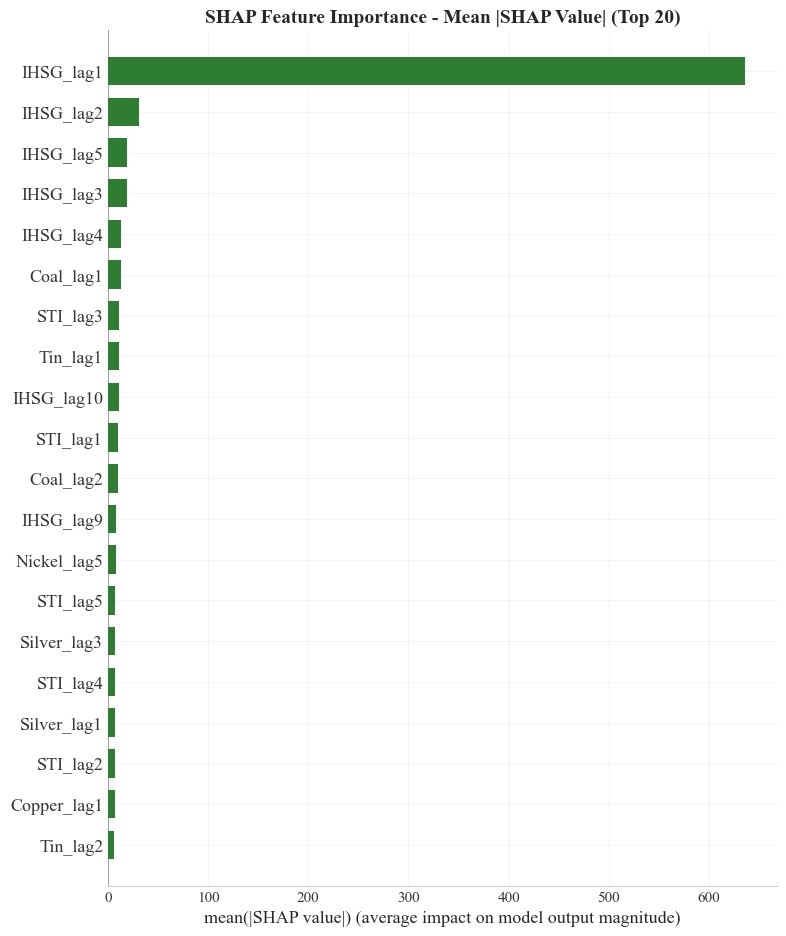

Figure saved: model2_shap_importance_bar.png (300 DPI)


In [29]:
# SHAP Summary Plot (Bar) with thesis color
fig, ax = plt.subplots(figsize=(12, 10))
shap.summary_plot(shap_values, X_sample_df, plot_type="bar", show=False, max_display=20, color=COLORS['IHSG'])
plt.title('SHAP Feature Importance - Mean |SHAP Value| (Top 20)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('model2_shap_importance_bar.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figure saved: model2_shap_importance_bar.png (300 DPI)")

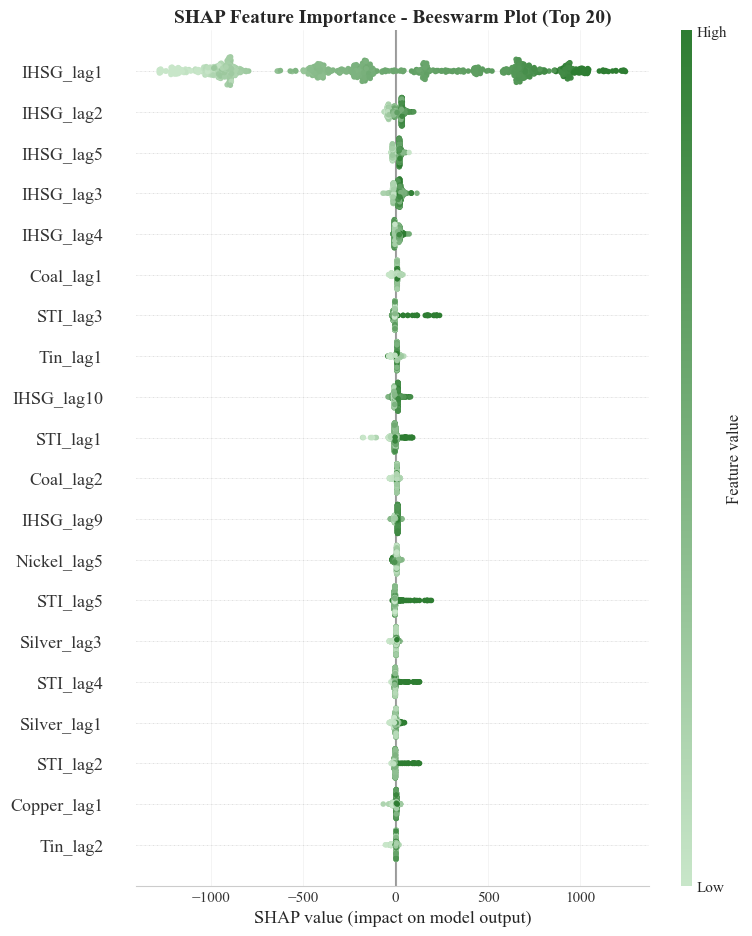

Figure saved: model2_shap_importance_beeswarm.png (300 DPI)


In [30]:
# SHAP Summary Plot (Beeswarm) with custom colormap
fig, ax = plt.subplots(figsize=(12, 12))

# Custom colormap for SHAP beeswarm (Green gradient)
from matplotlib.colors import LinearSegmentedColormap
shap_cmap = LinearSegmentedColormap.from_list('shap_green', ['#C8E6C9', '#2E7D32'], N=256)

shap.summary_plot(shap_values, X_sample_df, show=False, max_display=20, cmap=shap_cmap)
plt.title('SHAP Feature Importance - Beeswarm Plot (Top 20)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('model2_shap_importance_beeswarm.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figure saved: model2_shap_importance_beeswarm.png (300 DPI)")

In [31]:
# Calculate aggregated feature importance by variable (not by lag)
feature_importance_by_var = {}

for col in X_sample_df.columns:
    # Extract variable name (remove lag suffix)
    if '_lag' in col:
        var_name = col.rsplit('_lag', 1)[0]
    else:
        var_name = col
    
    col_idx = list(X_sample_df.columns).index(col)
    importance = np.abs(shap_values[:, col_idx]).mean()
    
    if var_name not in feature_importance_by_var:
        feature_importance_by_var[var_name] = 0
    feature_importance_by_var[var_name] += importance

# Sort by importance
sorted_importance = dict(sorted(feature_importance_by_var.items(), key=lambda x: x[1], reverse=True))

print("="*60)
print("AGGREGATED FEATURE IMPORTANCE BY VARIABLE")
print("="*60)
total_importance = sum(sorted_importance.values())
for var, importance in sorted_importance.items():
    pct = (importance / total_importance) * 100
    bar = "█" * int(pct / 2)
    print(f"{var:15} : {importance:8.4f} ({pct:5.2f}%) {bar}")

AGGREGATED FEATURE IMPORTANCE BY VARIABLE
IHSG            : 750.9484 (83.11%) █████████████████████████████████████████
STI             :  41.9381 ( 4.64%) ██
Coal            :  32.3635 ( 3.58%) █
Silver          :  25.8719 ( 2.86%) █
Tin             :  22.3253 ( 2.47%) █
Nickel          :  15.2624 ( 1.69%) 
Copper          :  14.8048 ( 1.64%) 


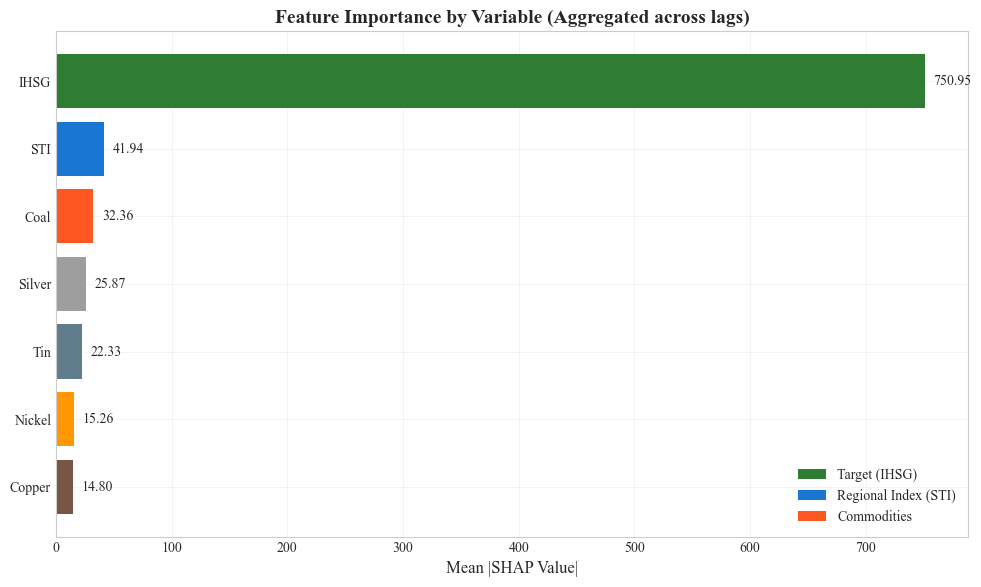

Figure saved: model2_feature_importance_aggregated.png (300 DPI)


In [32]:
# =========================================================================
# VISUALIZATION: AGGREGATED FEATURE IMPORTANCE
# =========================================================================
fig, ax = plt.subplots(figsize=(10, 6))

vars_names = list(sorted_importance.keys())
importances = list(sorted_importance.values())

# Color coding with thesis palette
bar_colors = []
for v in vars_names:
    if 'IHSG' in v:
        bar_colors.append(COLORS['IHSG'])
    elif 'STI' in v:
        bar_colors.append(COLORS['STI'])
    elif 'Coal' in v:
        bar_colors.append(COLORS['Coal'])
    elif 'Copper' in v:
        bar_colors.append(COLORS['Copper'])
    elif 'Silver' in v:
        bar_colors.append(COLORS['Silver'])
    elif 'Tin' in v:
        bar_colors.append(COLORS['Tin'])
    elif 'Nickel' in v:
        bar_colors.append(COLORS['Nickel'])
    else:
        bar_colors.append(COLORS['error'])

bars = ax.barh(vars_names[::-1], importances[::-1], color=bar_colors[::-1])
ax.set_xlabel('Mean |SHAP Value|', fontsize=12)
ax.set_title('Feature Importance by Variable (Aggregated across lags)', fontsize=14, fontweight='bold')

# Add value labels
for bar, val in zip(bars, importances[::-1]):
    ax.text(val + max(importances)*0.01, bar.get_y() + bar.get_height()/2, 
            f'{val:.2f}', va='center', fontsize=10)

# Add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor=COLORS['IHSG'], label='Target (IHSG)'),
    Patch(facecolor=COLORS['STI'], label='Regional Index (STI)'),
    Patch(facecolor=COLORS['Coal'], label='Commodities')
]
ax.legend(handles=legend_elements, loc='lower right', framealpha=0.9)

plt.tight_layout()
plt.savefig('model2_feature_importance_aggregated.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figure saved: model2_feature_importance_aggregated.png (300 DPI)")

## 11. Results Summary

In [33]:
# =========================================================================
# FINAL SUMMARY
# =========================================================================
print("="*70)
print("HASIL PENELITIAN MODEL 2: IHSG DENGAN KOMODITAS DAN STI (DAILY)")
print("="*70)

print("\nDATA:")
print(f"   - Periode Data     : {df['Date'].min().strftime('%d %B %Y')} - {df['Date'].max().strftime('%d %B %Y')}")
print(f"   - Total Observasi  : {len(df)} hari trading")
print(f"   - Train/Test Split : {TRAIN_RATIO*100:.0f}% / {(1-TRAIN_RATIO)*100:.0f}%")

print("\nTARGET:")
print(f"   - Variabel Target  : IHSG (Indeks Harga Saham Gabungan) - Daily")

print("\nCOVARIATES:")
print("   Regional Index:")
print("     1. STI (Straits Times Index)")
print("   Commodities:")
for i, col in enumerate(['Coal', 'Copper', 'Silver', 'Tin', 'Nickel'], 2):
    print(f"     {i}. {col}")

print("\nBEST HYPERPARAMETERS:")
for param, value in best_params.items():
    print(f"   - {param}: {value}")

print("\nMODEL PERFORMANCE (Random Forest):")
print(f"   - MAPE  : {mape_score:.4f}%")
print(f"   - RMSE  : {rmse_score:.4f}")
print(f"   - MAE   : {mae_score:.4f}")
print(f"   - R2    : {r2:.4f}")

print("\nFEATURE IMPORTANCE (SHAP - Top 3):")
for i, (var, imp) in enumerate(list(sorted_importance.items())[:3], 1):
    pct = (imp / total_importance) * 100
    print(f"   {i}. {var}: {pct:.2f}%")

print("\n" + "="*70)
print("Source: Author's calculation, 2025")
print("="*70)

HASIL PENELITIAN MODEL 2: IHSG DENGAN KOMODITAS DAN STI (DAILY)

DATA:
   - Periode Data     : 06 January 2015 - 30 December 2025
   - Total Observasi  : 2268 hari trading
   - Train/Test Split : 80% / 20%

TARGET:
   - Variabel Target  : IHSG (Indeks Harga Saham Gabungan) - Daily

COVARIATES:
   Regional Index:
     1. STI (Straits Times Index)
   Commodities:
     2. Coal
     3. Copper
     4. Silver
     5. Tin
     6. Nickel

BEST HYPERPARAMETERS:
   - lags: 10
   - lags_past_covariates: 5
   - n_estimators: 100
   - max_depth: 5
   - max_features: None
   - min_samples_split: 10
   - min_samples_leaf: 4
   - bootstrap: False
   - output_chunk_length: 1

MODEL PERFORMANCE (Random Forest):
   - MAPE  : 4.5024%
   - RMSE  : 528.3383
   - MAE   : 348.5931
   - R2    : -0.0240

FEATURE IMPORTANCE (SHAP - Top 3):
   1. IHSG: 83.11%
   2. STI: 4.64%
   3. Coal: 3.58%

Source: Author's calculation, 2025


In [34]:
# =========================================================================
# SAVE RESULTS
# =========================================================================
results_df = pd.DataFrame({
    'Date': test_actual.time_index,
    'Actual_IHSG': test_actual.values().flatten(),
    'Predicted_IHSG': predictions.values().flatten(),
    'Error': (predictions.values().flatten() - test_actual.values().flatten()),
    'APE_%': np.abs((predictions.values().flatten() - test_actual.values().flatten()) / test_actual.values().flatten()) * 100
})

results_df.to_csv('model2_predictions.csv', index=False)
print("Predictions saved to 'model2_predictions.csv'")

# Also save the merged dataset
df.to_csv('model2_merged_data.csv', index=False)
print("Merged dataset saved to 'model2_merged_data.csv'")

# Display prediction results
print("\nPrediction Results (first 10 rows):")
results_df.head(10).round(2)

Predictions saved to 'model2_predictions.csv'
Merged dataset saved to 'model2_merged_data.csv'

Prediction Results (first 10 rows):


,Date,Actual_IHSG,Predicted_IHSG,Error,APE_%
0,2023-10-19,6846.43,6888.52,42.09,0.61
1,2023-10-20,6849.17,6888.52,39.35,0.57
2,2023-10-23,6741.96,6888.52,146.56,2.17
3,2023-10-24,6806.76,6888.52,81.76,1.20
4,2023-10-25,6834.39,6792.25,-42.14,0.62
5,2023-10-26,6714.52,6888.52,174.00,2.59
6,2023-10-27,6758.79,6888.52,129.73,1.92
7,2023-10-30,6735.89,6792.25,56.35,0.84
8,2023-10-31,6752.21,6792.25,40.04,0.59
9,2023-11-01,6584.45,6792.25,207.79,3.16


## 12. Benchmark: XGBoost Model

In [35]:
# =========================================================================
# XGBOOST HYPERPARAMETER TUNING
# =========================================================================
from darts.models import XGBModel

print("="*60)
print("XGBOOST HYPERPARAMETER TUNING WITH OPTUNA")
print("="*60)
print(f"\nForecast Horizon: {OUTPUT_CHUNK_LENGTH} day(s) ahead")
print("\nSearch Space:")
print("  [Darts Parameters]")
print("  lags: [5, 10, 21, 42] (categorical)")
print("  lags_past_covariates: [5, 10, 21, 42] (categorical)")
print("\n  [XGBoost Parameters]")
print("  n_estimators: [100, 200, 300] (categorical)")
print("  max_depth: [3, 5, 7, 10] (categorical)")
print("  learning_rate: [0.01, 0.05, 0.1, 0.2] (categorical)")
print("  subsample: [0.6, 0.8, 1.0] (categorical)")
print("  colsample_bytree: [0.6, 0.8, 1.0] (categorical)")

XGBOOST HYPERPARAMETER TUNING WITH OPTUNA

Forecast Horizon: 1 day(s) ahead

Search Space:
  [Darts Parameters]
  lags: [5, 10, 21, 42] (categorical)
  lags_past_covariates: [5, 10, 21, 42] (categorical)

  [XGBoost Parameters]
  n_estimators: [100, 200, 300] (categorical)
  max_depth: [3, 5, 7, 10] (categorical)
  learning_rate: [0.01, 0.05, 0.1, 0.2] (categorical)
  subsample: [0.6, 0.8, 1.0] (categorical)
  colsample_bytree: [0.6, 0.8, 1.0] (categorical)


In [36]:
# =========================================================================
# XGBOOST OPTUNA OPTIMIZATION
# =========================================================================
import optuna
from optuna.samplers import TPESampler

optuna.logging.set_verbosity(optuna.logging.WARNING)

def xgb_objective(trial):
    """Objective function for XGBoost Optuna optimization"""
    
    # Darts parameters
    lags = trial.suggest_categorical('lags', [5, 10, 21, 42])
    lags_past_covariates = trial.suggest_categorical('lags_past_covariates', [5, 10, 21, 42])
    
    # XGBoost specific parameters
    n_estimators = trial.suggest_categorical('n_estimators', [100, 200, 300])
    max_depth = trial.suggest_categorical('max_depth', [3, 5, 7, 10])
    learning_rate = trial.suggest_categorical('learning_rate', [0.01, 0.05, 0.1, 0.2])
    subsample = trial.suggest_categorical('subsample', [0.6, 0.8, 1.0])
    colsample_bytree = trial.suggest_categorical('colsample_bytree', [0.6, 0.8, 1.0])
    
    try:
        model = XGBModel(
            lags=lags,
            lags_past_covariates=lags_past_covariates,
            output_chunk_length=OUTPUT_CHUNK_LENGTH,
            n_estimators=n_estimators,
            max_depth=max_depth,
            learning_rate=learning_rate,
            subsample=subsample,
            colsample_bytree=colsample_bytree,
            random_state=42,
            verbosity=0
        )
        
        model.fit(train_target_scaled, past_covariates=cov_scaled)
        
        backtest_pred = model.historical_forecasts(
            series=target_scaled,
            past_covariates=cov_scaled,
            start=test_target_scaled.start_time(),
            forecast_horizon=1,
            stride=1,
            retrain=False,
            verbose=False
        )
        
        mape_score = mape(test_target_scaled, backtest_pred)
        return mape_score
        
    except Exception as e:
        return float('inf')

def xgb_print_callback(study, trial):
    if trial.number % 10 == 0:
        print(f"  Trial {trial.number}: MAPE = {trial.value:.4f}% | Best so far: {study.best_value:.4f}%")

print("="*60)
print("RUNNING XGBOOST OPTUNA OPTIMIZATION")
print("="*60)

XGB_N_TRIALS = 100
total_xgb_combinations = 4 * 4 * 3 * 4 * 4 * 3 * 3
print(f"\nTotal possible combinations: {total_xgb_combinations}")
print(f"Number of trials: {XGB_N_TRIALS} ({XGB_N_TRIALS/total_xgb_combinations*100:.1f}% of search space)")
print(f"Forecast horizon: {OUTPUT_CHUNK_LENGTH} day (1-step-ahead)")
print("\nProgress (every 10 trials):")

xgb_study = optuna.create_study(
    direction='minimize',
    sampler=TPESampler(seed=42)
)

xgb_study.optimize(
    xgb_objective, 
    n_trials=XGB_N_TRIALS, 
    callbacks=[xgb_print_callback],
    show_progress_bar=True
)

xgb_best_params = xgb_study.best_trial.params.copy()
xgb_best_params['output_chunk_length'] = OUTPUT_CHUNK_LENGTH
xgb_best_score = xgb_study.best_value

print("\n" + "="*60)
print("XGBOOST OPTUNA RESULTS")
print("="*60)
print(f"Best MAPE Score: {xgb_best_score:.4f}%")
print(f"Total Trials: {len(xgb_study.trials)}")
print(f"\nBest Hyperparameters:")
for param, value in xgb_best_params.items():
    print(f"  {param}: {value}")

print("\n" + "="*60)
print("TOP 5 TRIALS")
print("="*60)
xgb_trials_df = xgb_study.trials_dataframe()
xgb_trials_df = xgb_trials_df.sort_values('value').head(5)
for idx, row in xgb_trials_df.iterrows():
    print(f"  Trial {row['number']}: MAPE = {row['value']:.4f}%")

RUNNING XGBOOST OPTUNA OPTIMIZATION

Total possible combinations: 6912
Number of trials: 100 (1.4% of search space)
Forecast horizon: 1 day (1-step-ahead)

Progress (every 10 trials):


  0%|          | 0/100 [00:00<?, ?it/s]

  Trial 0: MAPE = 13.2645% | Best so far: 13.2645%
  Trial 10: MAPE = 11.3320% | Best so far: 11.1409%
  Trial 20: MAPE = 23.9764% | Best so far: 11.1409%
  Trial 30: MAPE = 16.5621% | Best so far: 11.1409%
  Trial 40: MAPE = 15.3136% | Best so far: 11.1409%
  Trial 50: MAPE = 11.3218% | Best so far: 11.1409%
  Trial 60: MAPE = 16.0716% | Best so far: 9.6772%
  Trial 70: MAPE = 11.3733% | Best so far: 9.6772%
  Trial 80: MAPE = 11.2796% | Best so far: 9.6772%
  Trial 90: MAPE = 16.5229% | Best so far: 9.6772%

XGBOOST OPTUNA RESULTS
Best MAPE Score: 9.6772%
Total Trials: 100

Best Hyperparameters:
  lags: 42
  lags_past_covariates: 5
  n_estimators: 100
  max_depth: 3
  learning_rate: 0.1
  subsample: 1.0
  colsample_bytree: 0.6
  output_chunk_length: 1

TOP 5 TRIALS
  Trial 56: MAPE = 9.6772%
  Trial 58: MAPE = 10.1022%
  Trial 62: MAPE = 10.1022%
  Trial 61: MAPE = 10.1022%
  Trial 63: MAPE = 10.1022%


In [37]:
# =========================================================================
# TRAIN FINAL XGBOOST MODEL
# =========================================================================
print("\n" + "="*60)
print("TRAINING FINAL XGBOOST MODEL")
print("="*60)

xgb_final_model = XGBModel(
    lags=xgb_best_params['lags'],
    lags_past_covariates=xgb_best_params['lags_past_covariates'],
    output_chunk_length=OUTPUT_CHUNK_LENGTH,
    n_estimators=xgb_best_params['n_estimators'],
    max_depth=xgb_best_params['max_depth'],
    learning_rate=xgb_best_params['learning_rate'],
    subsample=xgb_best_params['subsample'],
    colsample_bytree=xgb_best_params['colsample_bytree'],
    random_state=42,
    verbosity=0
)

xgb_final_model.fit(train_target_scaled, past_covariates=cov_scaled)
print("XGBoost model trained successfully!")


TRAINING FINAL XGBOOST MODEL
XGBoost model trained successfully!


In [38]:
# =========================================================================
# XGBOOST PREDICTIONS & EVALUATION
# =========================================================================
xgb_predictions_scaled = xgb_final_model.historical_forecasts(
    series=target_scaled,
    past_covariates=cov_scaled,
    start=test_target_scaled.start_time(),
    forecast_horizon=1,
    stride=1,
    retrain=False,
    verbose=True
)

xgb_predictions = scaler_target.inverse_transform(xgb_predictions_scaled)

# Calculate metrics
xgb_mape = mape(test_actual, xgb_predictions)
xgb_rmse = rmse(test_actual, xgb_predictions)
xgb_mae = mae(test_actual, xgb_predictions)
xgb_r2 = r2_score(test_actual, xgb_predictions)

print("="*60)
print("XGBOOST MODEL EVALUATION")
print("="*60)
print(f"MAPE: {xgb_mape:.4f}%")
print(f"RMSE: {xgb_rmse:.4f}")
print(f"MAE:  {xgb_mae:.4f}")
print(f"R2:   {xgb_r2:.4f}")

historical forecasts:   0%|          | 0/1 [00:00<?, ?it/s]

XGBOOST MODEL EVALUATION
MAPE: 4.6320%
RMSE: 521.2633
MAE:  356.2205
R2:   0.0032


In [39]:
# =========================================================================
# MODEL COMPARISON: RANDOM FOREST vs XGBOOST
# =========================================================================
print("="*70)
print("MODEL COMPARISON: RANDOM FOREST vs XGBOOST")
print("="*70)

comparison_df = pd.DataFrame({
    'Metric': ['MAPE (%)', 'RMSE', 'MAE', 'R2'],
    'Random Forest': [mape_score, rmse_score, mae_score, r2],
    'XGBoost': [xgb_mape, xgb_rmse, xgb_mae, xgb_r2]
})

comparison_df['Winner'] = comparison_df.apply(
    lambda row: 'Random Forest' if (
        (row['Metric'] in ['MAPE (%)', 'RMSE', 'MAE'] and row['Random Forest'] < row['XGBoost']) or
        (row['Metric'] == 'R2' and row['Random Forest'] > row['XGBoost'])
    ) else 'XGBoost', axis=1
)

print(comparison_df.to_string(index=False))

rf_wins = (comparison_df['Winner'] == 'Random Forest').sum()
xgb_wins = (comparison_df['Winner'] == 'XGBoost').sum()

print("\n" + "="*70)
if rf_wins > xgb_wins:
    print(f"WINNER: Random Forest ({rf_wins}/4 metrics)")
elif xgb_wins > rf_wins:
    print(f"WINNER: XGBoost ({xgb_wins}/4 metrics)")
else:
    print(f"TIE: Both models perform similarly")
print("="*70)

MODEL COMPARISON: RANDOM FOREST vs XGBOOST
  Metric  Random Forest    XGBoost        Winner
MAPE (%)       4.502391   4.631952 Random Forest
    RMSE     528.338256 521.263300       XGBoost
     MAE     348.593093 356.220468 Random Forest
      R2      -0.024048   0.003195       XGBoost

TIE: Both models perform similarly


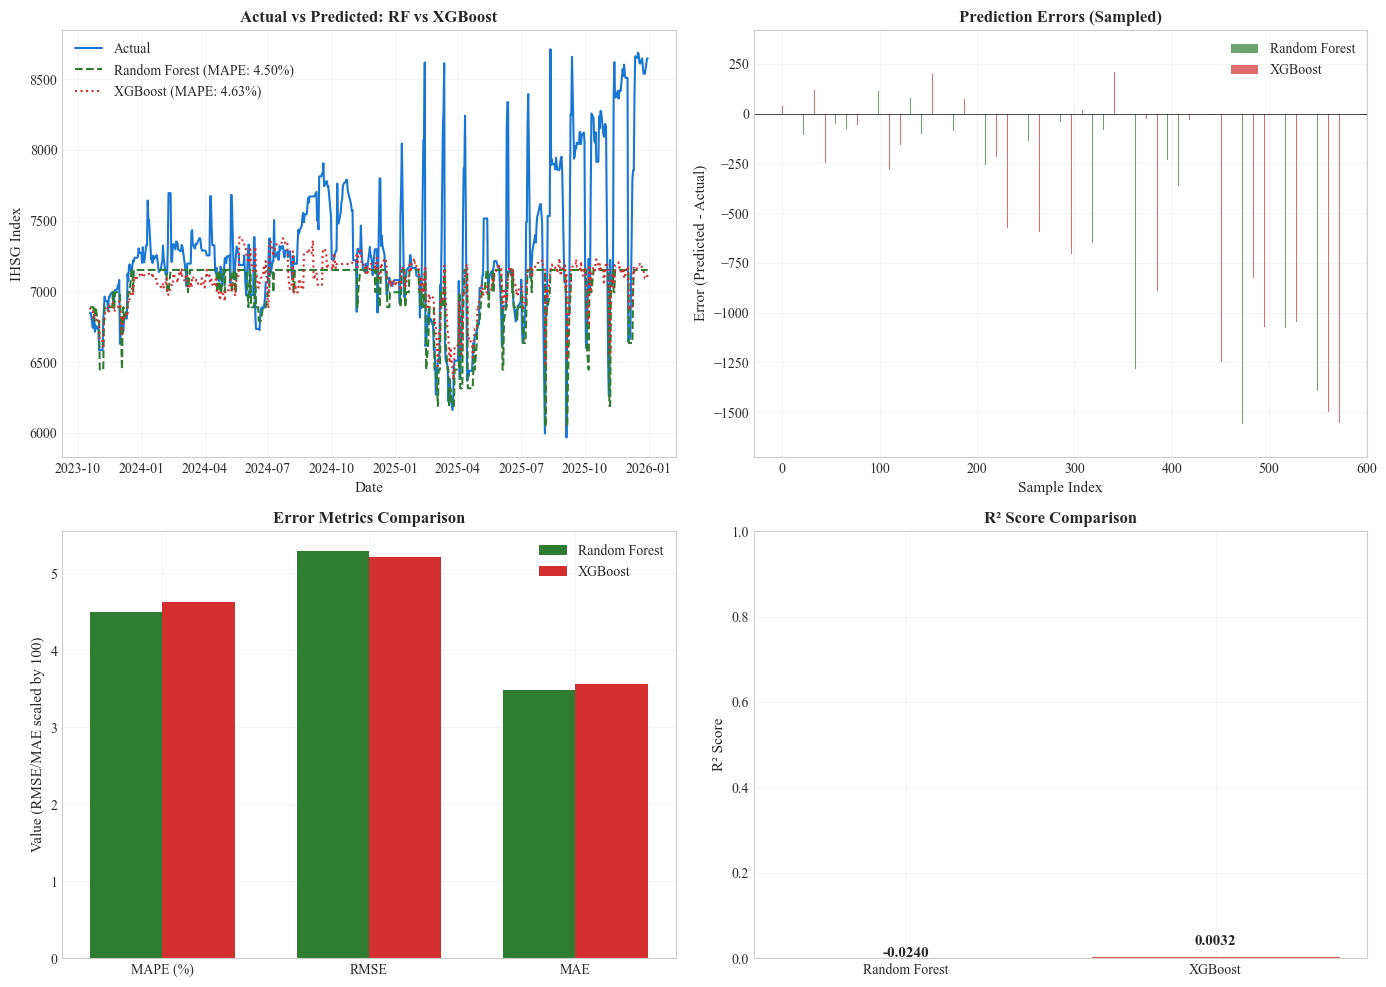

Figure saved: model2_comparison_rf_xgb.png (300 DPI)


In [40]:
# =========================================================================
# VISUALIZATION: RANDOM FOREST vs XGBOOST
# =========================================================================
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Actual vs Predictions (Both Models)
ax1 = axes[0, 0]
ax1.plot(test_actual.time_index, test_actual.values(), 
         label='Actual', color=COLORS['actual'], linewidth=1.5)
ax1.plot(predictions.time_index, predictions.values(), 
         label=f'Random Forest (MAPE: {mape_score:.2f}%)', 
         color=COLORS['IHSG'], linewidth=1.5, linestyle='--')
ax1.plot(xgb_predictions.time_index, xgb_predictions.values(), 
         label=f'XGBoost (MAPE: {xgb_mape:.2f}%)', 
         color=COLORS['predicted'], linewidth=1.5, linestyle=':')
ax1.set_title('Actual vs Predicted: RF vs XGBoost', fontsize=12, fontweight='bold')
ax1.set_xlabel('Date')
ax1.set_ylabel('IHSG Index')
ax1.legend(loc='upper left', framealpha=0.9)
ax1.grid(True, alpha=0.3)

# Plot 2: Prediction Errors
ax2 = axes[0, 1]
rf_errors = (predictions.values().flatten() - test_actual.values().flatten())
xgb_errors = (xgb_predictions.values().flatten() - test_actual.values().flatten())

# Sample for clearer visualization (daily data has many points)
sample_idx = np.arange(0, len(rf_errors), max(1, len(rf_errors)//50))
ax2.bar(sample_idx - 0.2, rf_errors[sample_idx], 0.4, 
        label='Random Forest', color=COLORS['IHSG'], alpha=0.7)
ax2.bar(sample_idx + 0.2, xgb_errors[sample_idx], 0.4, 
        label='XGBoost', color=COLORS['predicted'], alpha=0.7)
ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax2.set_title('Prediction Errors (Sampled)', fontsize=12, fontweight='bold')
ax2.set_xlabel('Sample Index')
ax2.set_ylabel('Error (Predicted - Actual)')
ax2.legend(loc='upper right', framealpha=0.9)
ax2.grid(True, alpha=0.3)

# Plot 3: Metrics Comparison Bar Chart
ax3 = axes[1, 0]
metrics = ['MAPE (%)', 'RMSE', 'MAE']
rf_values = [mape_score, rmse_score/100, mae_score/100]
xgb_values = [xgb_mape, xgb_rmse/100, xgb_mae/100]
x = np.arange(len(metrics))
width = 0.35
bars1 = ax3.bar(x - width/2, rf_values, width, label='Random Forest', color=COLORS['IHSG'])
bars2 = ax3.bar(x + width/2, xgb_values, width, label='XGBoost', color=COLORS['predicted'])
ax3.set_ylabel('Value (RMSE/MAE scaled by 100)')
ax3.set_title('Error Metrics Comparison', fontsize=12, fontweight='bold')
ax3.set_xticks(x)
ax3.set_xticklabels(metrics)
ax3.legend(loc='upper right', framealpha=0.9)
ax3.grid(True, alpha=0.3, axis='y')

# Plot 4: R² Comparison
ax4 = axes[1, 1]
models = ['Random Forest', 'XGBoost']
r2_values = [r2, xgb_r2]
colors_bar = [COLORS['IHSG'], COLORS['predicted']]
bars = ax4.bar(models, r2_values, color=colors_bar, alpha=0.8)
ax4.set_ylabel('R² Score')
ax4.set_title('R² Score Comparison', fontsize=12, fontweight='bold')
ax4.set_ylim(0, 1)
for bar, val in zip(bars, r2_values):
    ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
             f'{val:.4f}', ha='center', va='bottom', fontsize=11, fontweight='bold')
ax4.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('model2_comparison_rf_xgb.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figure saved: model2_comparison_rf_xgb.png (300 DPI)")

In [41]:
# =========================================================================
# DIAGNOSIS: WHY PREDICTIONS MAY APPEAR SIMILAR?
# =========================================================================
print("="*70)
print("MODEL WINDOW AND HORIZON EXPLANATION")
print("="*70)

print("\n1. FORECAST HORIZON (output_chunk_length):")
print(f"   - Value: {OUTPUT_CHUNK_LENGTH} day")
print("   - Meaning: Model predicts 1 day ahead at a time")
print("   - Each prediction is for t+1 given data up to t")

print(f"\n2. LOOKBACK WINDOW (lags):")
print(f"   - Target lags: {best_params['lags']} days")
print(f"   - Covariate lags: {best_params['lags_past_covariates']} days")
print(f"   - Meaning: Model uses {best_params['lags']} days of IHSG history")
print(f"             and {best_params['lags_past_covariates']} days of covariate history")

print("\n3. HOW historical_forecasts WORKS:")
print("   Day 1: Use [t-10, t-9, ..., t-1, t] → Predict t+1")
print("   Day 2: Use [t-9, t-8, ..., t, t+1_actual] → Predict t+2")
print("   Day 3: Use [t-8, t-7, ..., t+1, t+2_actual] → Predict t+3")
print("   ...")
print("   (Sliding window, always predicting 1-step ahead)")

print("\n4. POTENTIAL CAUSES OF SIMILAR PREDICTIONS:")

# Check prediction variance
pred_values = predictions.values().flatten()
pred_diff = np.diff(pred_values)
zero_diff_pct = (np.abs(pred_diff) < 0.01).sum() / len(pred_diff) * 100

print(f"\n   a) Prediction Variance Analysis:")
print(f"      - Std of predictions: {pred_values.std():.2f}")
print(f"      - Std of actuals: {test_actual.values().flatten().std():.2f}")
print(f"      - % of consecutive predictions with <0.01 diff: {zero_diff_pct:.1f}%")

# Check if ffill caused many duplicates
df_check = df_ts.copy()
duplicate_pct = (df_check.diff() == 0).mean() * 100
print(f"\n   b) Data after ffill (% unchanged from previous day):")
for col in ['IHSG'] + COVARIATE_COLS:
    dup_pct = (df_check[col].diff() == 0).sum() / len(df_check) * 100
    print(f"      {col}: {dup_pct:.1f}%")

print("\n5. INTERPRETATION:")
print("   - Random Forest tends to predict 'smoothed' values")
print("   - With short lags (10 days), recent trends dominate")
print("   - Tree-based models may predict similar values when")
print("     input features are similar (especially after ffill)")
print("   - This is normal behavior for RF on financial time series")

print("\n" + "="*70)

MODEL WINDOW AND HORIZON EXPLANATION

1. FORECAST HORIZON (output_chunk_length):
   - Value: 1 day
   - Meaning: Model predicts 1 day ahead at a time
   - Each prediction is for t+1 given data up to t

2. LOOKBACK WINDOW (lags):
   - Target lags: 10 days
   - Covariate lags: 5 days
   - Meaning: Model uses 10 days of IHSG history
             and 5 days of covariate history

3. HOW historical_forecasts WORKS:
   Day 1: Use [t-10, t-9, ..., t-1, t] → Predict t+1
   Day 2: Use [t-9, t-8, ..., t, t+1_actual] → Predict t+2
   Day 3: Use [t-8, t-7, ..., t+1, t+2_actual] → Predict t+3
   ...
   (Sliding window, always predicting 1-step ahead)

4. POTENTIAL CAUSES OF SIMILAR PREDICTIONS:

   a) Prediction Variance Analysis:
      - Std of predictions: 228.20
      - Std of actuals: 522.10
      - % of consecutive predictions with <0.01 diff: 74.0%

   b) Data after ffill (% unchanged from previous day):
      IHSG: 20.9%
      STI: 20.9%
      Coal: 26.7%
      Copper: 21.3%
      Silver: 20.